University of Helsinki, Master's Programme in Mathematics and Statistics  
MAST32001 Computational Statistics, Autumn 2023  
Luigi Acerbi  

# Week 6 exercises

## 1. Leapfrog integration in HMC (4 points)

In this exercise we will experiment with the leapfrog integrator used in HMC. As a target, we will use the 2D correlated normal 
$$ \pi(\boldsymbol{\theta}) = \mathcal{N}(\boldsymbol{\theta} ;\; 0, \boldsymbol{\Sigma}_2), $$
where $ \boldsymbol{\Sigma}_2 = \begin{pmatrix} 1 & \rho \\ \rho & 1 \end{pmatrix}$ with $\rho = 0.998$.

1. Simulate the system for $L=10$ leapfrog steps starting from the origin $\boldsymbol{\theta}_0 = (0, 0)$ with momentum $r = (1, 1/3)$ with several values of $\epsilon$ and plot the resulting Metropolis-Hastings acceptance probabilities $a$ at the end of the leapfrog trajectory. Considering values of $\epsilon \in [0.001, 0.1]$:
  - What is the smallest $\epsilon$ that will yield acceptance probability below 60%? 
  - What is the largest $\epsilon$ that will yield an acceptance probability above 10%?
  - For this exercise, the required tolerance on the answer is 0.001.
2. Simulate the Hamiltonian system for 500 leapfrog steps with $\epsilon=0.05$ starting from the origin $\boldsymbol{\theta}_0 = (0, 0)$ with momentum $r = (1, 1/3)$. Plot the trajectory and the Euclidean distance from the starting point at each point. 
  - How many leapfrog steps do you need to take until the trajectory reaches the first local maximum distance from the origin?
  - How many leapfrog steps (since the start of the trajectory) will lead you to the first local minimum?

*Note*: This exercise tests only the deterministic leapfrog integration used within the HMC algorithm to produce a single proposal. **This procedure is completely deterministic.** You will not need any random number generators in your solution. In particular, you will not need to run the full HMC algorithm or make any actual accept/reject decisions.

In [1]:
# Setup

import torch
import pandas as pd

from torch import tensor, Tensor
from typing import Callable
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

import dataclasses

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 150
sns.set_style("darkgrid")


torch.set_default_dtype(torch.double)
print(torch.get_default_dtype())

torch.float64


In [2]:
# 1.1

@dataclasses.dataclass
class LeapfrogResult:
    thetas: Tensor
    gradients: Tensor
    momentum: Tensor
    target_log_prob: Tensor
    epsilon: float
    neg_dH: float
    L: int

def q1_U(x: Tensor) -> Tensor:
    return -torch.sum(
        torch.distributions.MultivariateNormal(
            loc=tensor([0., 0.]), 
            covariance_matrix=tensor([
                [1., 0.998], 
                [0.998, 1.]
            ])
        ).log_prob(x)
    )

def q1_momentum() -> Tensor:
    return tensor([1., 1/3.])


def kinetic(p: Tensor) -> Tensor:
    return torch.dot(p, p) / 2

def leapfrog_integrator_q1(target: Callable[[Tensor], Tensor], momentum: Callable[[], Tensor], theta0: Tensor, epsilon: Tensor,  L: int) -> LeapfrogResult:

    thetas = torch.zeros((L + 1, 2))
    gradients = torch.zeros((L + 1, 2))
    target_log_prob = torch.zeros(L + 1)


    theta = theta0.clone().detach().requires_grad_(True)
    logP = target(theta)
    logP.backward()
    g = theta.grad

    thetas[0] = theta.data
    gradients[0] = g.data
    target_log_prob[0] = logP.data

    p = momentum()
    H = kinetic(p) - logP
    theta_new = theta.clone().detach().requires_grad_(True)
    g_new = g.clone().detach()

    for l in range(L):
        # Half step for momentum
        p.data -=  (epsilon * g_new.data / 2)

        # Full step for position
        theta_new.data += epsilon * p.data

        # Update gradient
        if theta_new.grad is not None:
            theta_new.grad.zero_()
        logP_new = target(theta_new)
        logP_new.backward()
        g_new = theta_new.grad

        # Half step for momentum
        p.data -= ( epsilon / 2 * g_new.data)

        target_log_prob[l + 1] = logP_new.data
        thetas[l + 1] = theta_new.data
        gradients[l + 1] = g_new.data

    logP_new = target(theta_new)
    H_new = kinetic(p) - logP_new
    neg_dH = torch.exp(-(H-H_new))
    return LeapfrogResult(thetas.detach(), gradients.detach(), p.detach(), target_log_prob.detach(), epsilon.detach().item(),  neg_dH.detach().item(), L)

q1_part_1_leapfrog_results: list[LeapfrogResult] = []
for e in torch.linspace(0.001, 0.1, 5000):
    leapfrog_result = leapfrog_integrator_q1(q1_U,  q1_momentum, tensor([0., 0.]), e, 10)
    q1_part_1_leapfrog_results.append(leapfrog_result)




/Users/sjack/Library/Caches/pypoetry/virtualenvs/computational-statistics-GjSql1OW-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sjack/Library/Caches/pypoetry/virtualenvs/computational-statistics-GjSql1OW-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sjack/Library/Caches/pypoetry/virtualenvs/computational-statistics-GjSql1OW-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', T

Text(0, 0.5, '$\\delta H$')

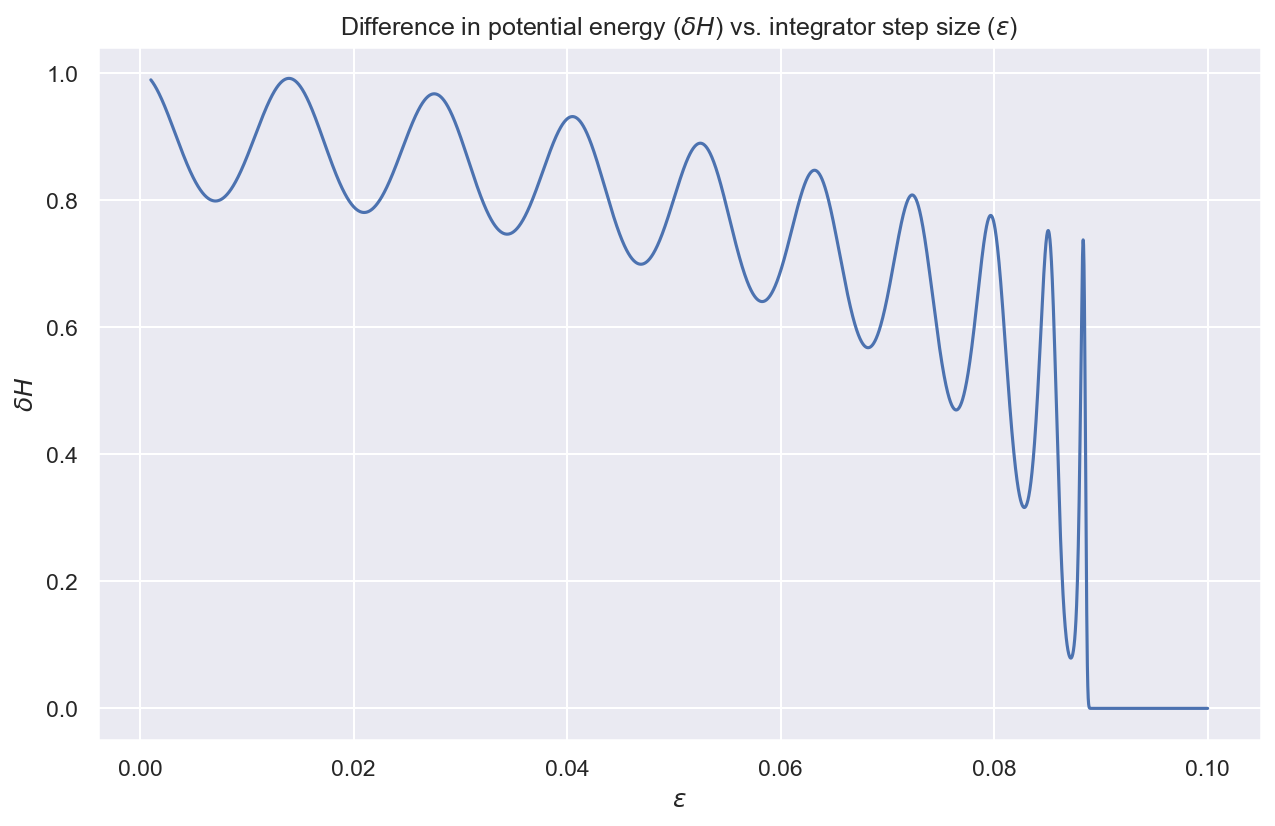

In [3]:
q1_1_df = pd.DataFrame.from_records([dataclasses.asdict(r) for r in q1_part_1_leapfrog_results], exclude=["thetas", "gradients", "momentum", "L"])
fig = sns.lineplot(data=q1_1_df, x="epsilon", y="neg_dH")
fig.set_title("Difference in potential energy ($\delta H$) vs. integrator step size ($\epsilon$)")
fig.set_xlabel("$\epsilon$")
fig.set_ylabel("$\delta H$")


In [4]:
q1_1_df[q1_1_df["neg_dH"] < 0.6]["epsilon"].min()

0.06704620924184837

In [5]:
q1_1_df[q1_1_df["neg_dH"]< 0.6].sort_values("epsilon")['epsilon'].iloc[0].item()

0.06704620924184837

In [6]:
# 1.1.1

print("Smallest epsilon with acceptance rate <60%: ", q1_1_df[q1_1_df["neg_dH"] < 0.6]["epsilon"].min())

# 1.1.2

print("Largest epsilon with acceptance rate >10%: ", q1_1_df[q1_1_df["neg_dH"] > 0.1]["epsilon"].max())

Smallest epsilon with acceptance rate <60%:  0.06704620924184837
Largest epsilon with acceptance rate >10%:  0.08869193838767754


In [7]:
q1part2_results = leapfrog_integrator_q1(
    target=q1_U,
    momentum=q1_momentum,
    theta0=tensor([0., 0.]),
    epsilon=tensor(.05),
    L=500,
)

/Users/sjack/Library/Caches/pypoetry/virtualenvs/computational-statistics-GjSql1OW-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sjack/Library/Caches/pypoetry/virtualenvs/computational-statistics-GjSql1OW-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sjack/Library/Caches/pypoetry/virtualenvs/computational-statistics-GjSql1OW-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', T

Text(0, 0.5, '$\\theta_2$')

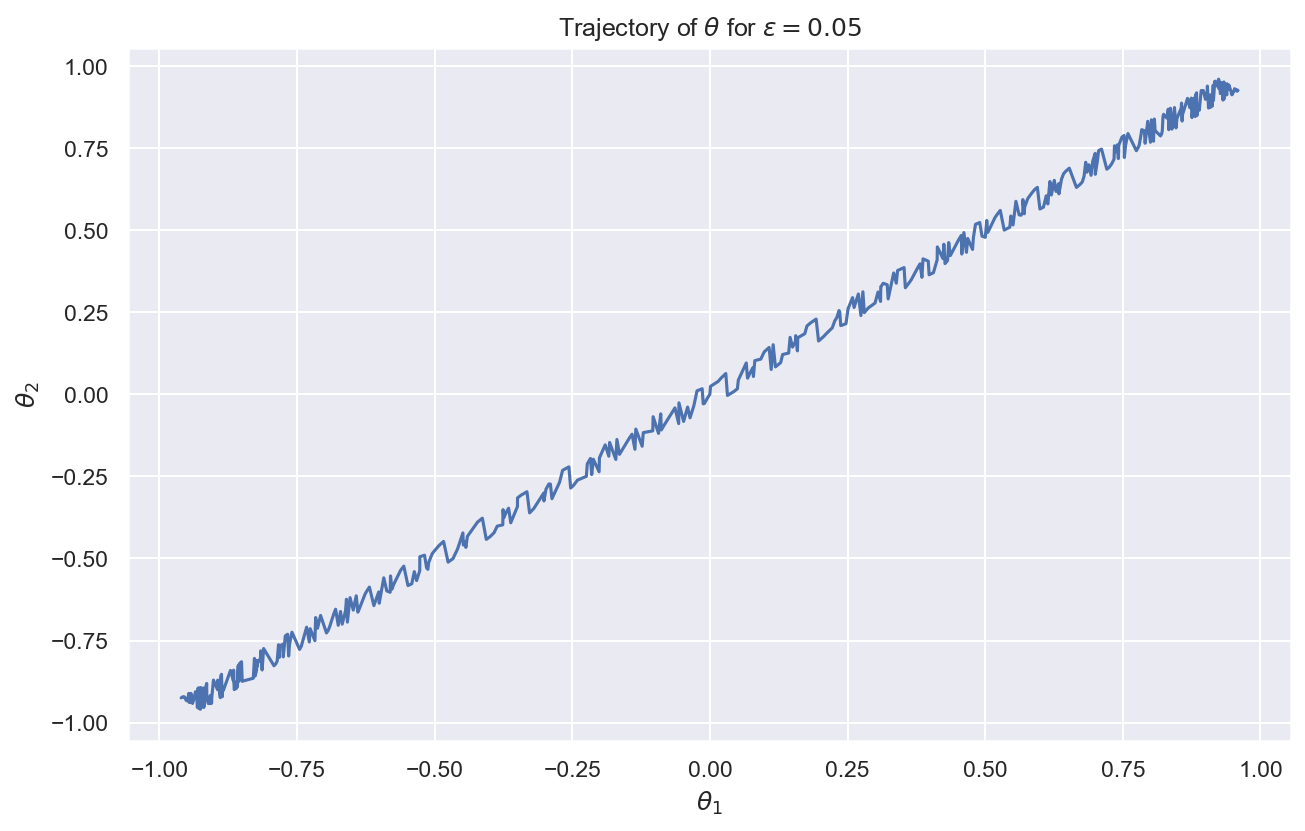

In [8]:
traj = q1part2_results.thetas

fig = sns.lineplot(x=traj[:, 0], y=traj[:, 1])
fig.set_title("Trajectory of $\\theta$ for $\\epsilon=0.05$")
fig.set_xlabel("$\\theta_1$")
fig.set_ylabel("$\\theta_2$")


/Users/sjack/Library/Caches/pypoetry/virtualenvs/computational-statistics-GjSql1OW-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sjack/Library/Caches/pypoetry/virtualenvs/computational-statistics-GjSql1OW-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sjack/Library/Caches/pypoetry/virtualenvs/computational-statistics-GjSql1OW-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', T

Text(0, 0.5, 'Distance from origin')

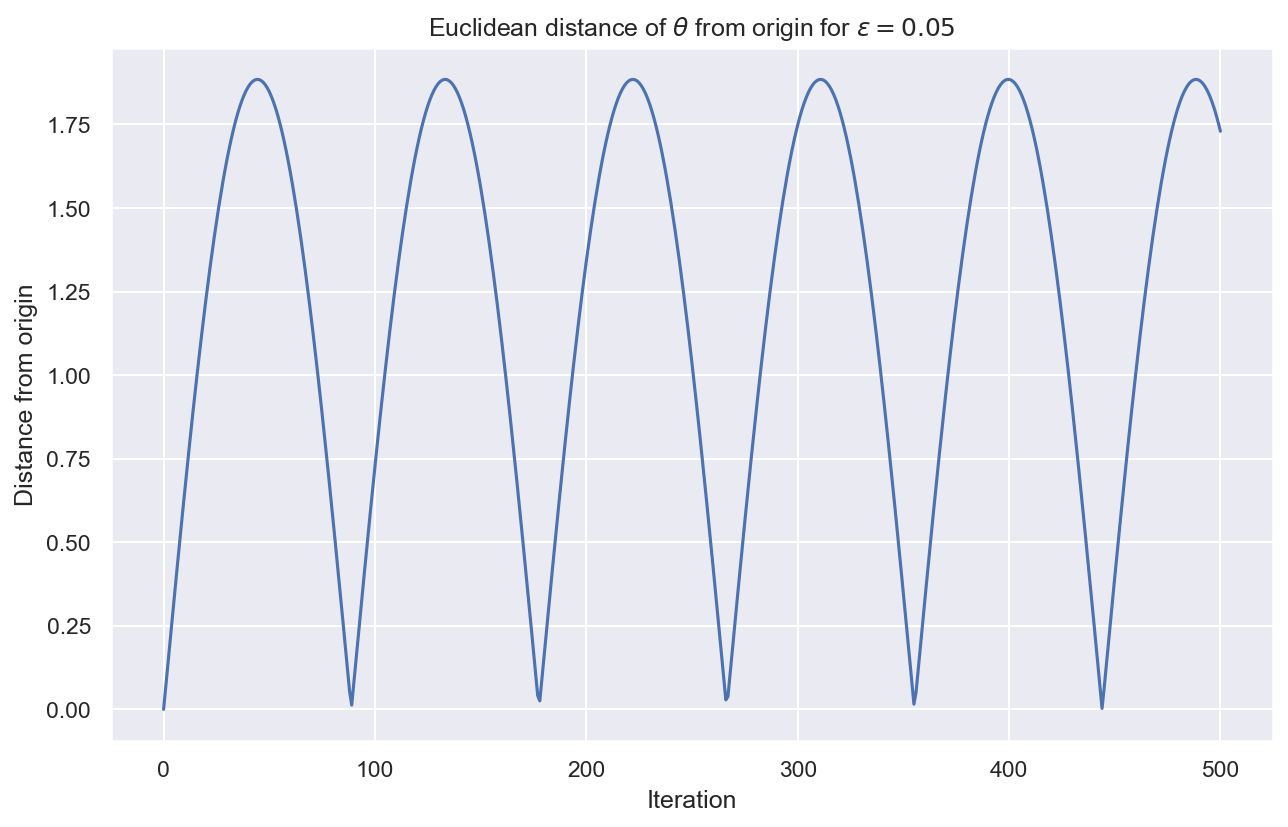

In [9]:
theta_euclidean_distance = torch.sqrt(((traj[:, 0] + traj[:, 1])**2))
fig = sns.lineplot(x=range(len(traj)), y=theta_euclidean_distance)
fig.set_title("Euclidean distance of $\\theta$ from origin for $\\epsilon=0.05$")
fig.set_xlabel("Iteration")
fig.set_ylabel("Distance from origin")

In [10]:
print(f"First local maximum at {torch.argmax(theta_euclidean_distance[:100]).item()+1} steps")

First local maximum at 45 steps


In [11]:
print(f"First local minimum at {torch.argmin(theta_euclidean_distance[1:120]).item()+1} steps")

First local minimum at 89 steps


## 2. Efficiency of "random walk" MCMC and HMC (4 points)

In this exercise we will test the efficiency of Metropolis-Hastings (also known as "random walk" MCMC) and HMC in terms of the distance covered in various situations. 

All the experiments are done using the same correlated normal target as in Exercise 1.
For Metropolis-Hastings MCMC, we will use as proposal $q(\boldsymbol{\theta}'; \boldsymbol{\theta}) = \mathcal{N}(\boldsymbol{\theta}'; \boldsymbol{\theta}, \sigma^2 \mathbf{I}_2)$ with $\sigma = 0.01$. For HMC, set $\epsilon=0.01$ and $L$ as specified below.

Distance covered here means the distance between the final point and the starting point of the chain, ignoring any intermediate steps.

1. Always starting at $\boldsymbol{\theta}_0 = (0, 0)$, run Metropolis-Hastings MCMC 100 times for 1 step and 100 times for 100 steps. Compute the average Euclidean distance covered from the starting point in each case. Compare the 100 step distance with the theoretical random walk scaling of $\sqrt{n}$ over $n$ steps.
2. Always starting at $\boldsymbol{\theta}_0 = (0, 0)$, run HMC 100 times for 1 step with $L=1$ and 100 times for 1 step with $L=100$. Compute the average Euclidean distance covered from the starting point in each case. Compare the 100 step distance with the theoretical random walk scaling of $\sqrt{n}$ over $n$ steps.
3. Repeat task 1 starting at $\boldsymbol{\theta}_0 = (-2, 2)$.
4. Repeat task 2 starting at $\boldsymbol{\theta}_0 = (-2, 2)$.
5. In each case, report the two average Euclidean distances in Moodle. In which cases do the algorithms move more quickly than would be expected for a random walk?

In [12]:
def hamiltonian_monte_carlo(theta0: Tensor,
                            n: int,
                            epsilon: Tensor,
                            momentum: Callable[..., Tensor],
                            L: int,
                            target: Callable[[Tensor], Tensor],
) -> tuple[Tensor, float]:
    samples = torch.zeros(size=(n, theta0.shape[0]))
    accepts = 0


    theta = theta0.clone().detach().requires_grad_(True)
    logP = target(theta)
    logP.backward()
    g = theta.grad


    for i in torch.arange(n):
        p = momentum()
        H = kinetic(p) - logP
        theta_new = theta.clone().detach().requires_grad_(True)
        g_new = g.clone().detach()
        for l in range(L):
            # Half step for momentum
            p.data -=  (epsilon * g_new.data / 2)

            # Full step for position
            theta_new.data += epsilon * p.data

            # Update gradient
            if theta_new.grad is not None:
                theta_new.grad.zero_()
            logP_new = target(theta_new)
            logP_new.backward()
            g_new = theta_new.grad

            # Half step for momentum
            p.data -= ( epsilon / 2 * g_new.data)

        logP_new = target(theta_new)
        H_new = kinetic(p) - logP_new
        neg_dH = torch.exp(-(H-H_new))

        if torch.rand(1) < neg_dH:
            accepts += 1
            theta = theta_new.clone().detach().requires_grad_(True)
            logP = logP_new.clone().detach()
            g = g_new.clone().detach()
        
        samples[i] = theta.clone().detach()

    return samples, accepts/n


In [13]:
# My week 3 MCMC sorted, but in torch
# 1

def metropolis_hastings(theta0: Tensor, 
                        n: int, 
                        log_target: Callable[..., Tensor], 
                        proposal: Callable[[float, float, float], Tensor],
                        proposal_sigma: float = 1.0,
                        proposal_scalar: float = 1.0
                        ) -> tuple[Tensor, float]:
    theta = theta0
    samples = torch.zeros(size=(n, theta0.shape[0]))
    accepts = 0
    for i in range(n):
        theta_prop = proposal(theta, proposal_scalar, proposal_sigma)
        u = torch.distributions.Uniform(0, 1).sample(sample_shape=(theta0.shape[0],))
        if (torch.log(u) < log_target(theta_prop) - log_target(theta)).all():
            theta = theta_prop
            accepts += 1
        samples[i] = theta
    return samples, accepts / n




In [14]:
ex2_momentum = lambda: torch.distributions.MultivariateNormal(loc=tensor([0., 0.]), covariance_matrix=torch.eye(2)).sample()
covariance_matrix = torch.eye(2) * (.01**2)
## PART 1
# 100 MCMC times, 1 step
distances_1_mcmc = torch.zeros(100)
for i in range(100):
    theta0 = tensor([0., 0.])
    samples, acceptance_rate = metropolis_hastings(
        theta0=theta0.clone(),
        n=1,
        log_target=lambda theta: -q1_U(theta),
        proposal = lambda theta, scalar, sigma: torch.distributions.MultivariateNormal(loc=theta, covariance_matrix=covariance_matrix).sample(),
    )
    assert samples.shape == (1, 2)
    distances_1_mcmc[i] = torch.norm(samples[-1] - theta0, p=2)
print(f"Mean distance from origin [MCMC 1 sample, 100 times]: {distances_1_mcmc.mean().item()}")

del(samples)


# 100 MCMC times, 100 steps
distances_2_mcmc = torch.zeros(100)
for i in range(100):
    theta0 = tensor([0., 0.])
    samples, acceptance_rate = metropolis_hastings(
        theta0=theta0.clone(),
        n=100,
        log_target=lambda theta: -q1_U(theta),
        proposal = lambda theta, scalar, sigma: torch.distributions.MultivariateNormal(loc=theta, covariance_matrix=covariance_matrix).sample(),
    )
    assert samples.shape == (100, 2)
    distances_2_mcmc[i] = torch.norm(samples[-1] - theta0, p=2)
print(f"Mean distance from origin [MCMC 100 samples, 100 times]: {distances_2_mcmc.mean().item()}")

del(samples)


## PART 2
# 100 HMC times, 1 step, L=1
distances_1_hmc = torch.zeros(100)
for i in range(100):
    theta0 = tensor([0., 0.])
    samples, acceptance_rate = hamiltonian_monte_carlo(
        theta0=theta0.clone(),
        n=1,
        epsilon=tensor(0.01),
        momentum=ex2_momentum,
        L=1,
        target=q1_U,
    )
    assert samples.shape == (1, 2)
    distances_1_hmc[i] = torch.norm(samples[-1] - theta0, p=2)
print(f"Mean distance from origin [HMC 1 sample, 100 times, L=1]: {distances_1_hmc.mean().item()}")

del(samples)


# 100 HMC times, 1 steps, L=100
distances_2_hmc = torch.zeros(100)
for i in range(100):
    theta0 = tensor([0., 0.])
    samples, acceptance_rate = hamiltonian_monte_carlo(
        theta0=theta0.clone(),
        n=1,
        epsilon=tensor(0.01),
        momentum=ex2_momentum,
        L=100,
        target=q1_U,
    )
    assert samples.shape == (1, 2)
    distances_2_hmc[i] = torch.norm(samples[-1] - theta0, p=2)
print(f"Mean distance from origin [HMC 1 sample, 100 times, L=100]: {distances_2_hmc.mean().item()}")

del(samples)


## Part 3
## Change theta0 to (-2, 2)
distances_1_mcmc_theta2 = torch.zeros(100)
for i in range(100):
    theta0 = tensor([-2., 2.])
    samples, acceptance_rate = metropolis_hastings(
        theta0=theta0.clone(),
        n=1,
        log_target=lambda theta: -q1_U(theta),
        proposal = lambda theta, scalar, sigma: torch.distributions.MultivariateNormal(loc=theta, covariance_matrix=covariance_matrix).sample(),
    )
    assert samples.shape == (1, 2)
    distances_1_mcmc_theta2[i] = torch.norm(samples[-1] - theta0, p=2)
print(f"Mean distance from origin [MCMC 1 sample, 100 times, theta0=(-2, 2)]: {distances_1_mcmc_theta2.mean().item()}")

del(samples)

distances_2_mcmc_theta2 = torch.zeros(100)
for i in range(100):
    theta0 = tensor([-2., 2.])
    samples, acceptance_rate = metropolis_hastings(
        theta0=theta0.clone(),
        n=100,
        log_target=lambda theta: -q1_U(theta),
        proposal = lambda theta, scalar, sigma: torch.distributions.MultivariateNormal(loc=theta, covariance_matrix=covariance_matrix).sample(),
    )
    assert samples.shape == (100, 2)
    distances_2_mcmc_theta2[i] = torch.norm(samples[-1] - theta0, p=2)
print(f"Mean distance from origin [MCMC 100 samples, 100 times, theta0=(-2, 2)]: {distances_2_mcmc_theta2.mean().item()}")

del(samples)


distances_1_hmc_theta2 = torch.zeros(100)
for i in range(100):
    theta0 = tensor([-2., 2.])
    samples, acceptance_rate = hamiltonian_monte_carlo(
        theta0=theta0.clone(),
        n=1,
        epsilon=tensor(0.01),
        momentum=ex2_momentum,
        L=1,
        target=q1_U,
    )
    assert samples.shape == (1, 2)
    distances_1_hmc_theta2[i] = torch.norm(samples[-1] - theta0, p=2)
print(f"Mean distance from origin [HMC 1 sample, L=1, theta0=(-2, 2)]: {distances_1_hmc_theta2.mean().item()}")

del(samples)


distances_2_hmc_theta2 = torch.zeros(100)
for i in range(100):
    theta0 = tensor([-2., 2.])
    samples, acceptance_rate = hamiltonian_monte_carlo(
        theta0=theta0.clone(),
        n=1,
        epsilon=tensor(0.01),
        momentum=ex2_momentum,
        L=100,
        target=q1_U,
    )
    assert samples.shape == (1, 2)
    distances_2_hmc_theta2[i] = torch.norm(samples[-1] - theta0, p=2)
print(f"Mean distance from origin [HMC 1 sample, L=100, theta0=(-2, 2)]: {distances_2_hmc_theta2.mean().item()}")

del(samples)


Mean distance from origin [MCMC 1 sample, 100 times]: 0.013321497211481593
Mean distance from origin [MCMC 100 samples, 100 times]: 0.09103877295629931
Mean distance from origin [HMC 1 sample, 100 times, L=1]: 0.010745973459828789
Mean distance from origin [HMC 1 sample, 100 times, L=100]: 0.3791304583084244
Mean distance from origin [MCMC 1 sample, 100 times, theta0=(-2, 2)]: 0.006424046039032111
Mean distance from origin [MCMC 100 samples, 100 times, theta0=(-2, 2)]: 0.4047890157352168
Mean distance from origin [HMC 1 sample, L=1, theta0=(-2, 2)]: 0.07080491637541896
Mean distance from origin [HMC 1 sample, L=100, theta0=(-2, 2)]: 5.483836090870054


## 3. NUTS simulation (6 points)

In this exercise we will experiment with the build-tree operation of the NUTS algorithm. We will use a simplified version of the algorithm with the following differences from the original:
* We will only extend the path forward instead of choosing the direction randomly.
* We will check for the termination condition only from the entire newly added path segment, not all subpaths as NUTS really would.

Your tasks:
1. Implement a simplified version of NUTS that works as follows:
  - Start at iteration $j = 1$.
  - In each iteration $j$, with $j = 1,2,\ldots$, set $L = 2^{j-1}$ and run $L$ leapfrog steps forward. Deterministically move to the new position (i.e., there is no acceptance check). 
  - At the end of each iteration, a "termination check" is run. The algorithm stops when the first newly simulated position $(\boldsymbol{\theta}^-, \mathbf{r}^-)$ and the last newly simulated position $(\boldsymbol{\theta}^+, \mathbf{r}^+)$ of the trajectory simulated in the current iteration segment satisfy
$$ (\boldsymbol{\theta}^+ - \boldsymbol{\theta}^-) \cdot \mathbf{r}^- < 0 \quad \text{or} \quad (\boldsymbol{\theta}^+ - \boldsymbol{\theta}^-) \cdot \mathbf{r}^+ < 0. $$
2. Run your algorithm on the 2D correlated normal with $\rho = 0.998$, starting from the origin $\boldsymbol{\theta}_0 = (0, 0)$ with momentum $\mathbf{r} = (1, 1/3)$ with $\epsilon=0.05$. At which iteration $j$ of the algorithm will the termination criterion be triggered for the first time? Report the iteration number in Moodle.
3. Compute the distance from the origin of the point at which the termination criterion is triggered, and report it in Moodle.
4. NUTS includes a special condition to simulate $u \sim \mathrm{Uniform}(0, \exp(-H(\boldsymbol{\theta}_0, \mathbf{r}_0))$ and ignoring all points where $u > \exp(-H(\boldsymbol{\theta}, \mathbf{r}))$. Assuming $u = 0.98\exp(-H(\boldsymbol{\theta}_0, \mathbf{r}_0))$ (a pretty extreme value), how many points from the trajectory of $2^j$ points generated during the first $j$ iterations (including the initial state and the one during which the termination condition was triggered first) would be included in the next step of the algorithm when choosing the next point?

In [18]:
def hamiltonian_monte_carlo_NUTS(theta0: Tensor,
                            n: int,
                            epsilon: Tensor,
                            momentum: Callable[..., Tensor],
                            target: Callable[[Tensor], Tensor],
) -> tuple[Tensor, float]:
    samples = torch.zeros(size=(n, theta0.shape[0]))
    accepts = 0


    theta = theta0.clone().detach().requires_grad_(True)
    logP = target(theta)
    logP.backward()
    g = theta.grad
    nuts_forward_tree = []

    for i in torch.arange(n):
        p = momentum()
        H = kinetic(p) - logP
        theta_new = theta.clone().detach().requires_grad_(True)
        g_new = g.clone().detach()
        j = 1
        while True: # NUTS loop
            
            theta_minus = theta_new.clone().detach().requires_grad_(True)
            p_minus = p.clone().detach()

            L = 2**(j-1)

            for l in range(L):
                # Half step for momentum
                p.data -=  (epsilon * g_new.data / 2)

                # Full step for position
                theta_new.data += epsilon * p.data

                # Update gradient
                if theta_new.grad is not None:
                    theta_new.grad.zero_()
                logP_new = target(theta_new)
                logP_new.backward()
                g_new = theta_new.grad

                # Half step for momentum
                p.data -= ( epsilon / 2 * g_new.data)

            theta_plus = theta_new.clone().detach().requires_grad_(True)
            p_plus = p.clone().detach()

            if torch.dot((theta_plus - theta_minus), p_minus) < 0 or torch.dot((theta_plus - theta_minus), p_plus) < 0:
                print(f"i: {i}, L: {L}, j: {j}. Rejecting theta_plus")
                print(f"Distance between theta_plus and theta_minus: {torch.norm(theta_plus - theta_minus, p=2)}")
                break # U-turn
            else:
                # Add theta_plus to forward tree, continue
                print(f"i: {i}, L: {L}, j: {j}. Adding theta_plus to forward tree")
                nuts_forward_tree.append((theta_plus, p_plus))
                theta_new = theta_plus.clone().detach().requires_grad_(True)
                p = p_plus.clone().detach()

            j += 1

        # NUTS has completed, recover values from forward tree
        theta_new = nuts_forward_tree[-1][0].clone().detach().requires_grad_(True)
        p = nuts_forward_tree[-1][1].clone().detach()

        logP_new = target(theta_new)
        H_new = kinetic(p) - logP_new
        neg_dH = torch.exp(-(H-H_new))

        if torch.rand(1) < neg_dH:
            accepts += 1
            theta = theta_new.clone().detach().requires_grad_(True)
            logP = logP_new.clone().detach()
            g = g_new.clone().detach()
        
        samples[i] = theta.clone().detach()

    return samples, accepts/n



hamiltonian_monte_carlo_NUTS(
    theta0=tensor([0., 0.]),
    n=100,
    epsilon=tensor(0.05),
    momentum=lambda: tensor([1., 1/3.]),
    target=q1_U,
)

i: 0, L: 1, j: 1. Adding theta_plus to forward tree
i: 0, L: 2, j: 2. Adding theta_plus to forward tree
i: 0, L: 4, j: 3. Adding theta_plus to forward tree
i: 0, L: 8, j: 4. Adding theta_plus to forward tree
i: 0, L: 16, j: 5. Adding theta_plus to forward tree
i: 0, L: 32, j: 6. Rejecting theta_plus
Distance between theta_plus and theta_minus: 0.13116517005039685
i: 1, L: 1, j: 1. Adding theta_plus to forward tree
i: 1, L: 2, j: 2. Adding theta_plus to forward tree
i: 1, L: 4, j: 3. Adding theta_plus to forward tree
i: 1, L: 8, j: 4. Adding theta_plus to forward tree
i: 1, L: 16, j: 5. Adding theta_plus to forward tree
i: 1, L: 32, j: 6. Rejecting theta_plus
Distance between theta_plus and theta_minus: 0.13116517005039685
i: 2, L: 1, j: 1. Adding theta_plus to forward tree
i: 2, L: 2, j: 2. Adding theta_plus to forward tree
i: 2, L: 4, j: 3. Adding theta_plus to forward tree
i: 2, L: 8, j: 4. Adding theta_plus to forward tree
i: 2, L: 16, j: 5. Adding theta_plus to forward tree
i: 2, L

(tensor([[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.8242, 0.8528],
         [0.8242, 0.8528],
         [1.1803, 1.2217],
         [1.1803, 1.2217],
         [1.4865, 1.5388],
         [1.7536, 1.8118],
         [1.7536, 1.8118],
         [1.9902, 1.9306],
         [1.9902, 1.9306],
         [1.9902, 1.9306],
         [1.9902, 1.9306],
         [1.9902, 1.9306],
         [1.9902, 1.9306],
         [1.9980, 2.1003],
         [1.9980, 2.1003],
         [1.9980, 2.1003],
         [2.2017, 2.0729],
         [2.2017, 2.0729],
         [2.2017, 2.0729],
         [2.2017, 2.0729],
         [2.2017, 2.0729],
         [2.2017, 2.0729],
         [2.2017, 2.0729],
         [2.2017, 2.0729],
         [2.2017, 2.0729],
         [2.1366, 2.3133],
         [2.1366, 2.3133],
         [2.1366, 2.3133],
         [2.1366, 2.3133],
         [2.1366, 2.3133],
         [2.1366, 2.3133],
         [2.1366, 2.3133],
 

## 4. HMC sampling for posterior inference (6 points)

In this task we will apply HMC sampling for posterior inference of a linear regression model.
We will use data from the Framingham Heart Study that studies the association between heart disease and its causes.
A description of the data and its fields can be found at http://www.maths.utas.edu.au/DHStat/Data/Flow.html (see also problem 10.4 in the computer tasks done in class).

We will use a linear regression model
$$ y_i = \mathbf{x}_i \boldsymbol{\beta} + \epsilon_i, $$
where $\mathbf{x}_i$ is a row vector of input variables and $\boldsymbol{\beta}$ is a column vector of regression coefficients, and the noise term $\epsilon_i$ follows the normal $\mathcal{N}(0, \sigma_y^2)$. We will not need a constant intercept term in the model because we will standardise the data.

Assuming the residuals $\epsilon_i, i=1,\dots,n$ are independent, the log-likelihood of the model is
$$ \log p(y | x, \boldsymbol{\beta}, \sigma_y) = \sum_{i=1}^n \log p(y_i | \boldsymbol{\beta}, x_i, \sigma_y) = \sum_{i=1}^n \log \mathcal{N}(y_i; \; \mathbf{x}_i \boldsymbol{\beta}, \sigma_y^2). $$

1. Load the data using the below code. Standardise the data (both $x$ and $y$) by subtracting the mean and dividing each variable by **two** standard deviations (see http://www.stat.columbia.edu/~gelman/research/published/standardizing7.pdf). Fit all the models using the standardised data as this makes sampling a lot easier.
2. Using the above log-likelihood and priors
$$ p(\boldsymbol{\beta}) = \prod_j p(\beta_j) = \prod_j \mathcal{N}(\beta_j;\; 0, 2^2), \\ p(\sigma_y) = \mathrm{Gamma}(\sigma_y;\; k=10, \theta=0.1),$$
use HMC or NUTS to draw samples from the posterior distribution $p(\boldsymbol{\beta}, \sigma_y | x, y)$, when the prediction target variable $y$ is 'SBP' and the input variables $x$ are 'FRW', 'AGE' and 'CHOL'.

To ensure the standard deviation $\sigma_y$ is positive, express it as $\sigma_y = \exp(s_y)$, where $s_y$ is unbounded. Remember to apply the density transformation to transform the prior over $\sigma_y$ to that over $s_y$!

Make sure your sampler is properly tuned so that results will be reliable.

Report your estimates of the posterior means and standard deviations of the coefficient in $\beta$ for 'FRW', and of $s_y$. (*Note*: This should be $s_y$, not $\sigma_y$!)

Implementations of the gamma log-pdf needed for the prior that are compatible with Autograd and PyTorch are provided below for your convenience. (Autograd does not support `scipy.stats.gamma.logpdf` to the level we need. The PyTorch library implementation uses a different parametrisation, so the below implementation is easier for consistency.)

The required tolerance is $\pm 0.01$.

*Note*: The NUTS implementation provided in the course materials sometimes gets stuck and produces a sample with really small variance. If you encounter such behaviour, you should disregard such results.

In [16]:
# For PyTorch
import pandas as pd
import torch

def standardize(x: Tensor) -> Tensor:
    # scale each variable invididually
    return (x - x.mean(dim=0)) / (x.std(dim=0)*2)

# load the data from CSV file using pandas
fram = pd.read_csv('https://raw.githubusercontent.com/lacerbi/compstats-files/main/data/fram.txt', sep='\t')
# convert the variables of interest to numpy arrays for autograd compatibility
# input: Framingham relative weight - the ratio of the subjects weight to the median weight for their sex-height group,
#   age and cholesterole level
x = fram[['FRW', 'AGE', 'CHOL']].values.astype(float)
# target: Systolic blood pressure, examination 1
y = fram['SBP'].values.squeeze().astype(float)

x = torch.tensor(x, dtype=torch.double)
y = torch.tensor(y, dtype=torch.double)

xs = standardize(x)
ys = standardize(y)

def gamma_logpdf(x: Tensor, k: Tensor, theta: Tensor) -> Tensor:
    """Gamma distribution log pdf (PyTorch)."""    
    return -torch.lgamma(k) - k*torch.log(theta) + (k-1)*torch.log(x) - x / theta


def log_beta_prior(beta: Tensor) -> Tensor:
    return torch.sum(torch.distributions.Normal(loc=0, scale=2**2).log_prob(beta))

def log_sigma_prior(sigma: Tensor) -> Tensor:
    return gamma_logpdf(sigma, tensor(10), tensor(.1))

def log_prior(s: Tensor, beta: Tensor) -> Tensor:
    sigma = torch.exp(s)
    return log_sigma_prior(sigma) + log_beta_prior(beta) + s

def log_likelihood(x: Tensor, y: Tensor, beta: Tensor, s: Tensor, ) -> Tensor:
    sigma = torch.exp(s)
    return torch.sum(torch.distributions.Normal(loc=x @ beta, scale=sigma).log_prob(y))

def log_posterior(x: Tensor, y: Tensor, beta: Tensor, s: Tensor) -> Tensor:
    return log_prior(s, beta) + log_likelihood(x, y, beta, s)


In [17]:
n_samples = 10_000
n_chains = 4
beta_1_samples = torch.zeros(n_samples//2, n_chains, )
beta_2_samples = torch.zeros(n_samples//2, n_chains)
beta_3_samples = torch.zeros(n_samples//2, n_chains)
s_samples = torch.zeros(n_samples//2, n_chains)
for i in range(n_chains):
    samples, acceptance = hamiltonian_monte_carlo_NUTS(
        theta0=torch.zeros(4),
        n=n_samples,
        epsilon=tensor(.001),
        momentum=lambda: torch.distributions.MultivariateNormal(loc=torch.zeros(4), covariance_matrix=torch.eye(4)).sample(),
        L=5,
        target=lambda theta: -log_posterior(xs, ys, theta[:3], theta[-1]),
    )
    beta_1_samples[:, i] = samples[n_samples//2:, 0]
    beta_2_samples[:, i] = samples[n_samples//2:, 1]
    beta_3_samples[:, i] = samples[n_samples//2:, 2]
    s_samples[:, i] = samples[n_samples//2:, 3]
    print(f"acceptance rate={acceptance}")



TypeError: hamiltonian_monte_carlo_NUTS() got an unexpected keyword argument 'L'

In [ ]:
# plot the line with the data
fig = plt.figure(figsize=(16, 8))
plt.scatter(xs[:, 0], ys, alpha=.1)
plt.xlabel('Weight, Age, Cholesterol (Normalised)')
plt.ylabel('Systolic blood pressure (Normalised)')

beta1_hat = beta_1_samples.mean()
beta2_hat = beta_2_samples.mean()
beta3_hat = beta_3_samples.mean()

x1 = torch.linspace(xs[:, 0].min(), xs[:, 0].max(), 100)
x2 = torch.linspace(xs[:, 1].min(), xs[:, 1].max(), 100)
x3 = torch.linspace(xs[:, 2].min(), xs[:, 2].max(), 100)
y_hat = beta1_hat * x1 + beta2_hat * x2 + beta3_hat * x3

plt.plot(x1, y_hat, color='red', linewidth=3)

mse = torch.mean((ys - (xs @ torch.tensor([beta1_hat, beta2_hat, beta3_hat])))**2)

plt.title(f'Linear regression with Hamiltonian MCMC (MSE={mse:.2f})')
plt.show()


In [ ]:
#Histplot of beta params
fig, ax = plt.subplots(1, 3, figsize=(16, 8))
sns.histplot(beta_1_samples.mean(dim=1), ax=ax[0], bins=50)
sns.histplot(beta_2_samples.mean(dim=1), ax=ax[1], bins=50)
sns.histplot(beta_3_samples.mean(dim=1), ax=ax[2], bins=50)
ax[0].set_title(f"$\\beta_1$ (mean={beta_1_samples.mean().item():.2f}), sd={beta_1_samples.std().item():.2f}")
ax[1].set_title(f"$\\beta_2$ (mean={beta_2_samples.mean().item():.2f}), sd={beta_2_samples.std().item():.2f}")
ax[2].set_title(f"$\\beta_3$ (mean={beta_3_samples.mean().item():.2f}), sd={beta_3_samples.std().item():.2f}")
plt.show()

In [ ]:
#Histplot of s and sigma
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
sns.histplot(s_samples.mean(dim=1), ax=ax[0], bins=50)
sns.histplot(torch.exp(s_samples.mean(dim=1)), ax=ax[1], bins=50)
ax[0].set_title(f"$s$ (mean={s_samples.mean().item():.2f}), sd={s_samples.std().item():.2f}")
ax[1].set_title(f"$\\sigma$ (mean={torch.exp(s_samples.mean()).item():.2f}), sd={torch.exp(s_samples.std()).item():.2f}")
plt.show()


In [ ]:
beta_1_samples.mean(dim=0).std(), beta_1_samples.std(dim=0).std()

In [ ]:
s_samples.mean(dim=0).std(), s_samples.std(dim=0).std()

In [ ]:
beta_1_samples.mean(dim=0).mean(), beta_1_samples.std(dim=0).mean()

In [ ]:
s_samples.mean(dim=0).mean(), s_samples.std(dim=0).mean()